In [142]:
# !pip install -U torchtext==0.17.2

In [143]:
# !pip install contractions

In [144]:
# !pip install vaderSentiment

In [100]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator

import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load Data and EDA

In [101]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [102]:
train = pd.read_csv('/content/drive/My Drive/code/Tweet/train.csv', encoding='latin-1')
test = pd.read_csv('/content/drive/My Drive/code/Tweet/test.csv', encoding='latin-1')

In [103]:
train.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [104]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

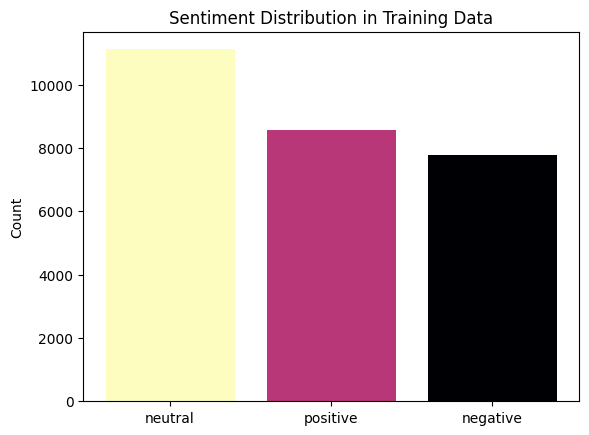

In [105]:
sentiment_counts = train['sentiment'].value_counts()

ranks = np.argsort(np.argsort(sentiment_counts.values))
colors = plt.cm.magma (ranks / max(ranks))

plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)
plt.ylabel("Count")
plt.title("Sentiment Distribution in Training Data")
plt.show()

Use only text and sentiment columns

In [106]:
col = ['text', 'sentiment']

train_df = train[col]
test_df = test[col]

## Prepare Sentiment Labels

In [107]:
sentiment_to_index = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
  }

train_df.loc[:, 'sentiment'] = train_df['sentiment'].map(sentiment_to_index)
test_df.loc[:, 'sentiment'] = test_df['sentiment'].map(sentiment_to_index)

In [108]:
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


## Prepare Text Data

### Adjust Words based on REGEX

In [109]:
def remove_special_character(text):
    text=re.sub('<.*?>', ' ', text)
    text=re.sub('<.*>','',text)
    text=re.sub('http\S+|https\S+|www\S+','',text)
    text=re.sub('@\S+|#\S+','',text)
    # Keep apostrophes only if inside words (like "I'm", "don't")
    text = re.sub('`', "'",  text)
    text = re.sub(r"[^\w\s']", '', text)
    return text

In [110]:
import contractions

# couldn't -> could not
def expand_contractions(text):
    text = contractions.fix(text)
    return text

In [111]:
train_df.loc[:, 'text'] = train_df['text'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)
test_df.loc[:, 'text'] = test_df['text'].str.lower().str.strip().apply(remove_special_character).apply(expand_contractions)

In [112]:
train_df.head()

,text,sentiment
0,i would have responded if i were going,1
1,sooo sad i will miss you here in san diego,0
2,my boss is bullying me,0
3,what interview leave me alone,0
4,sons of why could not they put them on the re...,0


### Tokenize

In [113]:
train_data = []

for _, row in train_df.iterrows():
    text = row["text"]
    tokens = word_tokenize(text)
    train_data.append([row["sentiment"], tokens])

In [114]:
train_data[:3]

[[1, ['i', 'would', 'have', 'responded', 'if', 'i', 'were', 'going']],
 [0,
  ['sooo', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego']],
 [0, ['my', 'boss', 'is', 'bullying', 'me']]]

In [115]:
test_data = []

for _, row in test_df.iterrows():
    text = row["text"]
    tokens = word_tokenize(text)
    test_data.append([row["sentiment"], tokens])

In [116]:
test_data[:3]

[[1, ['last', 'session', 'of', 'the', 'day']],
 [2,
  ['shanghai',
   'is',
   'also',
   'really',
   'exciting',
   'precisely',
   'skyscrapers',
   'galore',
   'good',
   'tweeps',
   'in',
   'china',
   'sh',
   'bj']],
 [0,
  ['recession',
   'hit',
   'veronique',
   'branquinho',
   'she',
   'has',
   'to',
   'quit',
   'her',
   'company',
   'such',
   'a',
   'shame']]]

### Remove stop words and Apply Stemming

In [117]:
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy

nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words("english"))

def preprocess_tokens(tokens):
    processed_tokens = []
    for token_list in tokens:
        label, words = token_list[0], token_list[1]
        filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords

        lemmatized_words = []
        for doc in nlp.pipe(filtered_words, disable=["parser", "ner"]):
            lemmatized_words.append(doc[0].lemma_)

        processed_tokens.append([label, lemmatized_words])
    return processed_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [118]:
train_processed = preprocess_tokens(train_data)
train_processed[:5]

[[1, ['would', 'respond', 'go']],
 [0, ['sooo', 'sad', 'miss', 'san', 'diego']],
 [0, ['boss', 'bully']],
 [0, ['interview', 'leave', 'alone']],
 [0, ['son', 'could', 'put', 'release', 'already', 'buy']]]

In [119]:
test_processed = preprocess_tokens(test_data)
test_processed[:5]

[[1, ['last', 'session', 'day']],
 [2,
  ['shanghai',
   'also',
   'really',
   'exciting',
   'precisely',
   'skyscraper',
   'galore',
   'good',
   'tweep',
   'china',
   'sh',
   'bj']],
 [0,
  ['recession', 'hit', 'veronique', 'branquinho', 'quit', 'company', 'shame']],
 [2, ['happy', 'birthday']],
 [2, ['like']]]

### Build Vocabulary (Word-to-Index Mapping)

In [120]:
def yield_tokens(data):
    for d in data:
        yield d[1]

vocab = build_vocab_from_iterator(yield_tokens(train_processed), specials=["<unk>"]) # adds a special token <unk> (for unknown words).
vocab.set_default_index(index=vocab["<unk>"]) # unknown words (words not in vocab) get mapped to <unk> (index 0).

### Encode text

In [121]:
encoded_train = [[label, vocab(tokens)] for label, tokens in train_processed]
encoded_train[:5]

[[1, [28, 1190, 1]],
 [0, [295, 62, 22, 1104, 1859]],
 [0, [1004, 3717]],
 [0, [770, 68, 364]],
 [0, [583, 55, 182, 759, 128, 146]]]

In [122]:
test_encoded = [[label, vocab(tokens)] for label, tokens in test_processed]
print(test_encoded[:5])

[[1, [44, 903, 3]], [2, [0, 163, 24, 707, 18202, 0, 6459, 5, 1261, 1719, 7572, 0]], [0, [4145, 286, 0, 0, 1025, 585, 595]], [2, [19, 133]], [2, [7]]]


### Batch Collation

In [123]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(_label)
         processed_text = torch.tensor(_text, dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0)) # Stores sequence length in offsets to track where each sample starts

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0) # Store cumulative sequence positions.
    text_list = torch.cat(text_list)

    return label_list.to(device), text_list.to(device), offsets.to(device)

In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

False


### Create PyTorch DataLoader

In [125]:
batch_size = 32
num_class = 3

train_encoded, val_encoded = train_test_split(encoded_train, test_size=0.05, shuffle=True)

train_loader = DataLoader(train_encoded, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_encoded, batch_size=64, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_encoded, batch_size=64, shuffle=False, collate_fn=collate_batch)

## Data Prediction by My TextClassificationModel

### Compute Class Weight

In [126]:
from collections import Counter

label_counts = Counter([entry[0] for entry in train_processed])

# Compute weights
total_samples = sum(label_counts.values())
class_weights = {label: total_samples / count for label, count in label_counts.items()}

num_classes = max(class_weights.keys()) + 1  # Ensure tensor has enough space for all classes
weight_tensor = torch.zeros(num_classes)
for label, weight in class_weights.items():
    weight_tensor[label] = weight

# Define loss function with computed class weights
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

print("Class Weights Tensor:", weight_tensor)

Class Weights Tensor: tensor([3.5317, 2.4719, 3.2021])


### Initialize Model

In [127]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        dropout = self.dropout(embedded)
        return self.fc(dropout)

model = TextClassificationModel(len(vocab), embed_dim=50, num_class=3).to(device)

In [128]:
criterion = nn.CrossEntropyLoss(weight=weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training and Validation Loop

In [129]:
def train_and_validate_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, patience, device):
    min_val_loss = float('inf')
    count = 0
    best_model_state = None

    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for epoch in range(1, num_epochs+1):
        model.train()
        training_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training phase
        for idx, (labels, text, offsets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(text, offsets)
            loss = criterion(outputs, labels).mean()
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = training_loss / len(train_loader)
        epoch_train_acc = correct_train / total_train
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)

        # Validation phase
        model.eval()
        validation_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for idx, (labels, text, offsets) in enumerate(val_loader):
                outputs = model(text, offsets)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = validation_loss / len(val_loader)
        epoch_val_acc = correct_val / total_val
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Early stopping
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            count = 0
            best_epoch = epoch
            best_model_state = model.state_dict()
        else:
            count += 1
            if count >= patience:
                print(f"Early stopping triggered at epoch {epoch}. Best Val Loss: {min_val_loss:.4f} at Epoch {best_epoch}/{num_epochs}")
                break

    return best_model_state, train_loss, val_loss

In [130]:
best_model_state, train_loss, val_loss = train_and_validate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=20,
    patience=5,
    device=device
)

Epoch 1/20 - Train Loss: 1.0275, Train Acc: 0.4629 | Val Loss: 0.8925, Val Acc: 0.6128
Epoch 2/20 - Train Loss: 0.8491, Train Acc: 0.6094 | Val Loss: 0.8028, Val Acc: 0.6448
Epoch 3/20 - Train Loss: 0.7544, Train Acc: 0.6729 | Val Loss: 0.7768, Val Acc: 0.6652
Epoch 4/20 - Train Loss: 0.6988, Train Acc: 0.7049 | Val Loss: 0.7718, Val Acc: 0.6630
Epoch 5/20 - Train Loss: 0.6504, Train Acc: 0.7354 | Val Loss: 0.7753, Val Acc: 0.6667
Epoch 6/20 - Train Loss: 0.6153, Train Acc: 0.7573 | Val Loss: 0.7865, Val Acc: 0.6645
Epoch 7/20 - Train Loss: 0.5846, Train Acc: 0.7711 | Val Loss: 0.7957, Val Acc: 0.6638
Epoch 8/20 - Train Loss: 0.5540, Train Acc: 0.7874 | Val Loss: 0.8107, Val Acc: 0.6594
Epoch 9/20 - Train Loss: 0.5285, Train Acc: 0.8001 | Val Loss: 0.8262, Val Acc: 0.6557
Early stopping triggered at epoch 9. Best Val Loss: 0.7718 at Epoch 4/20


In [131]:
if best_model_state:
    model.load_state_dict(best_model_state)

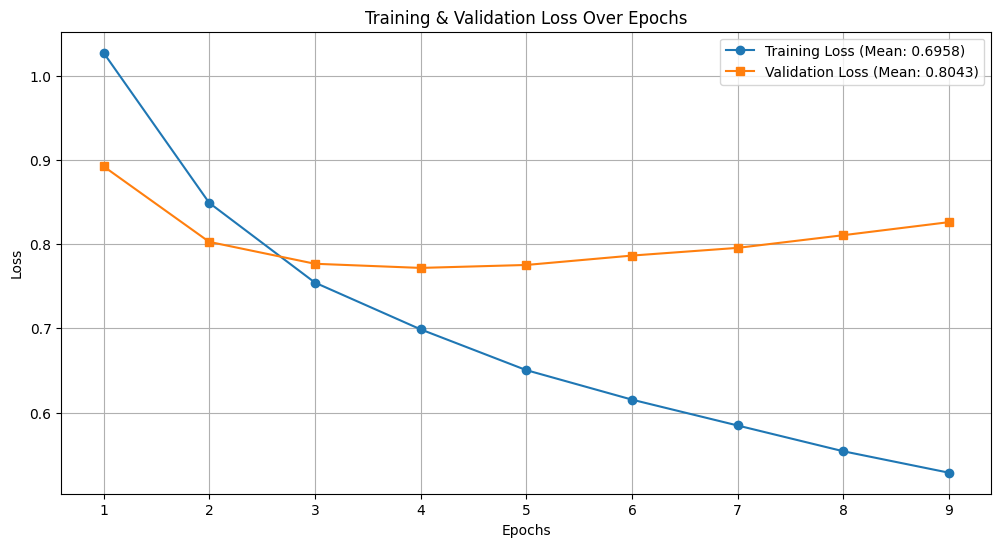

In [132]:
mean_train_loss = sum(train_loss) / len(train_loss)
mean_val_loss = sum(val_loss) / len(val_loss)

range_epoch = len(train_loss)

# Plot the Loss Curve
plt.figure(figsize=(12, 6))
plt.plot(range(1, range_epoch + 1), train_loss, label=f'Training Loss (Mean: {mean_train_loss:.4f})', marker='o')
plt.plot(range(1, range_epoch + 1), val_loss, label=f'Validation Loss (Mean: {mean_val_loss:.4f})', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training & Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

### Testing Loop

In [133]:
import csv

model.eval()

with torch.no_grad(), open('predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'predicted'])

    for idx, (label, text, offsets) in enumerate(test_loader):
        outputs = model(text, offsets)  # Shape: (batch_size, num_classes)
        predicted = outputs.argmax(dim=1)  # Shape: (batch_size,)

        # Loop through batch and save each prediction
        for i, pred in enumerate(predicted.tolist()):
            writer.writerow([idx * test_loader.batch_size + i, pred])

In [134]:
test_pred = pd.read_csv('/content/predictions.csv')

In [135]:
test_results = pd.concat([test_df.reset_index(drop=True), test_pred], axis=1).drop(columns=['id'])
test_results[50:61]

,text,sentiment,predicted
50,is watching acoustic performances in the mood...,1,2
51,i will oscillate from one to the other,1,0
52,i am so very tiredand have insomnia,0,0
53,thanks ennio,2,2
54,you should totally come get me and bring me to...,1,1
55,you seem nice you are generous and you know yo...,2,2
56,you so dirrrrrty why oh why did i pick the haw...,1,1
57,almost got a kitty yesterdaybut it did not wor...,1,1
58,reality needs to check in schools over time to...,1,1
59,caladesi was definitely a nice peaceful way to...,2,2


### Evaluation

In [136]:
class_names = ["Negative", "Neutral", "Positive"]
true = test_results['sentiment'].astype(int)
pred = test_results['predicted'].astype(int)

report = classification_report(true, pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    Negative       0.60      0.72      0.66      1001
     Neutral       0.63      0.62      0.62      1430
    Positive       0.77      0.66      0.71      1103

    accuracy                           0.66      3534
   macro avg       0.67      0.66      0.66      3534
weighted avg       0.67      0.66      0.66      3534



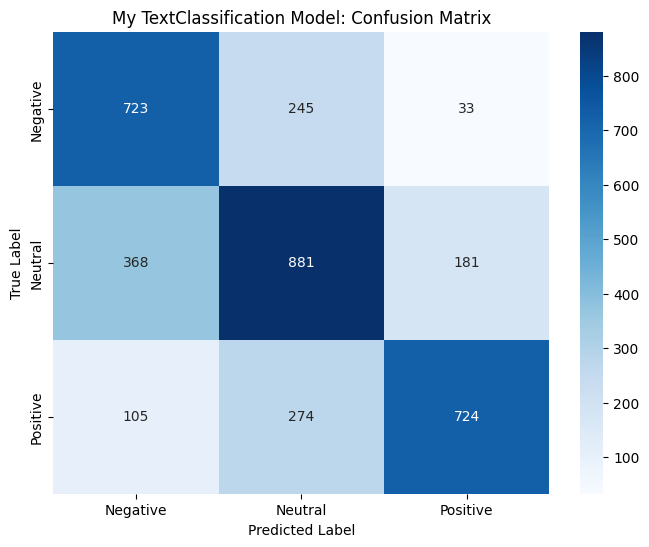

In [137]:
cm = confusion_matrix(true, pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("My TextClassification Model: Confusion Matrix")
plt.show()

## Data Prediction by NLTK SentimentIntensityAnalyzer

In [138]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [139]:
# Define ranges for tuning
pos_thresholds = np.arange(0.3, 0.35, 0.01)
neg_thresholds = np.arange(0.01 ,0.05, 0.005)

best_f1 = 0
best_thresholds = (0, 0)

for pos_t in pos_thresholds:
    for neg_t in neg_thresholds:
        test_labels = []
        test_predict = []

        # Convert tokenized words to text and get sentiment score
        def get_sentiment(words):
            text = ' '.join(words)
            scores = analyzer.polarity_scores(text)

            if scores['pos'] > scores['neg'] + pos_t:
                return 2  # Positive
            elif scores['neg'] > scores['pos'] + neg_t:
                return 0  # Negative
            else:
                return 1  # Neutral

        # Generate predictions for test set
        for label, words in test_processed:
            sentiment = get_sentiment(words)

            test_labels.append(label)
            test_predict.append(sentiment)

        # Evaluate performance
        report = classification_report(test_labels, test_predict, output_dict=True)
        f1_macro = report['macro avg']['f1-score']  # Use macro F1-score for balance

        if f1_macro > best_f1:
            best_f1 = f1_macro
            best_thresholds = (pos_t, neg_t)
            best_predict = test_predict.copy()

        print(f"Pos Threshold: {pos_t:.4f}, Neg Threshold: {neg_t:.4f}, F1-Score: {f1_macro:.4f}")

print(f"Best Thresholds: Positive = {best_thresholds[0]:.4f}, Negative = {best_thresholds[1]:.4f}, Best F1-Score = {best_f1:.4f}")

Pos Threshold: 0.3000, Neg Threshold: 0.0100, F1-Score: 0.6616
Pos Threshold: 0.3000, Neg Threshold: 0.0150, F1-Score: 0.6621
Pos Threshold: 0.3000, Neg Threshold: 0.0200, F1-Score: 0.6626
Pos Threshold: 0.3000, Neg Threshold: 0.0250, F1-Score: 0.6629
Pos Threshold: 0.3000, Neg Threshold: 0.0300, F1-Score: 0.6606
Pos Threshold: 0.3000, Neg Threshold: 0.0350, F1-Score: 0.6610
Pos Threshold: 0.3000, Neg Threshold: 0.0400, F1-Score: 0.6607
Pos Threshold: 0.3000, Neg Threshold: 0.0450, F1-Score: 0.6591
Pos Threshold: 0.3100, Neg Threshold: 0.0100, F1-Score: 0.6629
Pos Threshold: 0.3100, Neg Threshold: 0.0150, F1-Score: 0.6634
Pos Threshold: 0.3100, Neg Threshold: 0.0200, F1-Score: 0.6640
Pos Threshold: 0.3100, Neg Threshold: 0.0250, F1-Score: 0.6642
Pos Threshold: 0.3100, Neg Threshold: 0.0300, F1-Score: 0.6619
Pos Threshold: 0.3100, Neg Threshold: 0.0350, F1-Score: 0.6623
Pos Threshold: 0.3100, Neg Threshold: 0.0400, F1-Score: 0.6621
Pos Threshold: 0.3100, Neg Threshold: 0.0450, F1-Score:

In [140]:
report2 = classification_report(test_labels, best_predict, target_names=class_names)
print(report2)

              precision    recall  f1-score   support

    Negative       0.73      0.59      0.65      1001
     Neutral       0.62      0.68      0.65      1430
    Positive       0.68      0.71      0.69      1103

    accuracy                           0.66      3534
   macro avg       0.68      0.66      0.67      3534
weighted avg       0.67      0.66      0.66      3534



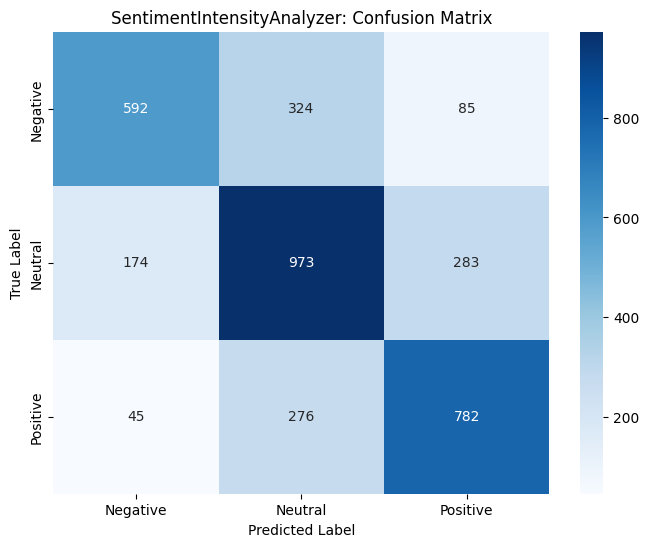

In [141]:
cm2 = confusion_matrix(test_labels, best_predict)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("SentimentIntensityAnalyzer: Confusion Matrix")
plt.show()